In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.wrapper_files.random_data_gen_mod import *
from loda_dumb import LODA
from fed_loda import FedLODA
from sklearn.metrics import average_precision_score, roc_auc_score, recall_score
from scipy.stats import spearmanr
from scipy.io import loadmat

In [2]:
datasets = {"musk":{}, "satimage":{}, "shuttle":{}}

shuttle = loadmat('data/shuttle.mat')
shuttle_df_orig = pd.DataFrame(shuttle['X'], columns=[f"x{i}" for i in range(1, 10)])
shuttle_df_orig['y'] = shuttle['y']
shuttle_df = shuttle_df_orig.sample(frac=1).reset_index(drop=True)
datasets["shuttle"]["data"] = shuttle_df.iloc[:,:-1]
datasets["shuttle"]["clss"] = shuttle_df['y']
datasets["shuttle"]["contam"] = shuttle_df['y'].mean()


satimage = loadmat('data/satimage-2.mat')
satimage_df = pd.DataFrame(satimage['X'], columns=[f"x{i}" for i in range(1, 37)])
satimage_df['y'] = satimage['y']
datasets["satimage"]["data"] = satimage_df.iloc[:,:-1]
datasets["satimage"]["clss"] = satimage_df['y']
datasets["satimage"]["contam"] = satimage_df['y'].mean()


musk = loadmat('data/musk.mat')
musk_df = pd.DataFrame(musk['X'], columns=[f"x{i}" for i in range(1, 167)])
musk_df['y'] = musk['y']
datasets["musk"]["data"] = musk_df.iloc[:,:-1]
datasets["musk"]["clss"] = musk_df['y']
datasets["musk"]["contam"] = musk_df['y'].mean()

In [3]:
from sklearn.model_selection import train_test_split

def feder_strat_split(df, k):
    Xy_0 = np.array_split(df[df.iloc[:,-1]==0], k)
    Xy_1 = np.array_split(df[df.iloc[:,-1]==1], k)
    Xy = []
    for i, j in zip(Xy_0, Xy_1):
        Xy.append(pd.concat([i,j]))
    
    X_list=[]
    y_list=[]
    for sub in Xy:
        X_list.append(sub.iloc[:,:-1])
        y_list.append(sub.iloc[:,-1])
    
    X_train_l, X_test_l, y_train_l, y_test_l = [], [], [], []
    for X, y in zip(X_list, y_list):
        X_train, X_test, y_train, y_test =\
            train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        X_train_l.append(X_train)
        X_test_l.append(X_test)
        y_train_l.append(y_train)
        y_test_l.append(y_test)

    assert len(X_train_l)==len(X_test_l)==len(y_train_l)==len(y_test_l)==k

    for i, j in zip(X_train_l, y_train_l):
        assert i.shape[0] == j.shape[0] 
    for i, j in zip(X_test_l, y_test_l):
        assert i.shape[0] == j.shape[0] 

    return X_train_l, X_test_l, y_train_l, y_test_l








In [4]:
print(datasets["shuttle"]["data"].shape)
print(datasets["satimage"]["data"].shape)
print(datasets["musk"]["data"].shape)

(49097, 9)
(5803, 36)
(3062, 166)


In [5]:
X_train, X_test, y_train, y_test = feder_strat_split(shuttle_df, 10)

for i, j, k, l in zip(X_train, X_test, y_train, y_test):
    print(i.shape, k.shape, k.sum())
    print(j.shape, l.shape, l.sum())

(4419, 9) (4419,) 317
(492, 9) (492,) 35
(4419, 9) (4419,) 316
(491, 9) (491,) 35
(4419, 9) (4419,) 316
(491, 9) (491,) 35
(4419, 9) (4419,) 316
(491, 9) (491,) 35
(4419, 9) (4419,) 316
(491, 9) (491,) 35
(4419, 9) (4419,) 316
(491, 9) (491,) 35
(4418, 9) (4418,) 316
(491, 9) (491,) 35
(4418, 9) (4418,) 316
(491, 9) (491,) 35
(4418, 9) (4418,) 316
(491, 9) (491,) 35
(4418, 9) (4418,) 316
(491, 9) (491,) 35


In [21]:
    
floda = FedLODA(
n_random_cuts = 500, standardize=False
)
floda.fit(X_train, y_train)


(4419, 500)
(4419, 500)
(4419, 500)
(4419, 500)
(4419, 500)
(4419, 500)
(4418, 500)
(4418, 500)
(4418, 500)
(4418, 500)
 29%|██▉       | 147/500 [00:00<00:00, 1455.32it/s][31979  9967  7228 31184   408  2528   490 11089  7926  7283 21469   324
  2448 36061 18209 40548  2182  6704 26304 34139 17788 32242   279  6269
 10568 11737 54973  1759 14408   677   655 25158 14366 33121 38581 18709
   869 18212 29416 17708 21177  5677 17188  4389 27185  7756  3406 43682
  4848  4254 15072 46922 41581 19252 10136  4075 53069   359 33610 13564
 13936 12197 34046   335   505  1962 33420 24040  3830   711 11437 11130
 18814 11817  5859  7392 41103  2316  4152  4798 22928 34248  9210 12177
 42779  9117 12971  5414  9290 45896   866 21888  7753  2202 49391  1021
 26665 67355   524  9373  1387 37846 10204 38049 33467  2650 12409 48097
 45441   274   508 21963  4812 15433 16819   461  3291  2488 31335 15139
   293  8604   181 12453 34068   682  6068   378 22740 21410 34264 89728
 39750 45050 17295  6476  

In [7]:
np.bincount(np.array([ 1, 1, 3, 2, 1, 7]), minlength=12)

array([0, 3, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [17]:
lod = LODA(
n_random_cuts = 100, dens_estim_method="histogram")
lod.fit(datasets["shuttle"]["data"])


100%|██████████| 100/100 [00:00<00:00, 393.06it/s]


In [13]:
datasets["shuttle"]["data"].shape

(49097, 9)

In [18]:
for i, j in zip(lod.hists_, lod.prnbins_):
    print(i.shape, np.zeros(j).shape)

(1400,) (1400,)
(2728,) (2728,)
(3566,) (3566,)
(7239,) (7239,)
(4187,) (4187,)
(789,) (789,)
(5270,) (5270,)
(5953,) (5953,)
(10296,) (10296,)
(1513,) (1513,)
(15691,) (15691,)
(1628,) (1628,)
(654,) (654,)
(3339,) (3339,)
(8201,) (8201,)
(636,) (636,)
(4287,) (4287,)
(5304,) (5304,)
(1400,) (1400,)
(1562,) (1562,)
(3426,) (3426,)
(2836,) (2836,)
(12206,) (12206,)
(4110,) (4110,)
(319,) (319,)
(2868,) (2868,)
(9635,) (9635,)
(1774,) (1774,)
(2345,) (2345,)
(5529,) (5529,)
(1272,) (1272,)
(1756,) (1756,)
(2979,) (2979,)
(1896,) (1896,)
(491,) (491,)
(7732,) (7732,)
(821,) (821,)
(6903,) (6903,)
(1184,) (1184,)
(1627,) (1627,)
(2657,) (2657,)
(16205,) (16205,)
(33235,) (33235,)
(1934,) (1934,)
(2601,) (2601,)
(2870,) (2870,)
(176,) (176,)
(478,) (478,)
(5917,) (5917,)
(607,) (607,)
(1737,) (1737,)
(3642,) (3642,)
(3791,) (3791,)
(1182,) (1182,)
(5966,) (5966,)
(667,) (667,)
(229,) (229,)
(8449,) (8449,)
(5620,) (5620,)
(4147,) (4147,)
(1707,) (1707,)
(1967,) (1967,)
(2097,) (2097,)
(798

In [22]:
for i, (x_tr, x_te, y_tr, y_te) in enumerate(zip(X_train, X_test, y_train, y_test)):
    print(f"\nAgent_{i}:")

    scorez_tr = floda.models[i].decision_scores_
    decis_tr = floda.models[i].labels_

    scorez_te = floda.models[i].decision_function(x_te)
    decis_te = floda.models[i].predict(x_te)

    scorez_fed_tr = floda.decision_function(x_tr)
    scorez_fed_te = floda.decision_function(x_te)

    # print("Conf. matrix:\n", confusion_matrix(clss, decis_1))
    # print(classification_report(seismic_numeric[' class'], decis))
    auc_tr = roc_auc_score(y_tr, scorez_tr)
    ap_tr = average_precision_score(y_tr, scorez_tr)
    # ap_alt = average_precision_score(y_tr, decis_tr)
    auc_te = roc_auc_score(y_te, scorez_te)
    ap_te = average_precision_score(y_te, scorez_te)
    # ap_alt_te = average_precision_score(y_te, decis_te)

    auc_f_tr = roc_auc_score(y_tr, scorez_fed_tr)
    ap_f_tr = average_precision_score(y_tr, scorez_fed_tr)
    # ap_alt = average_precision_score(y_tr, decis_tr)
    auc_f_te = roc_auc_score(y_te, scorez_fed_te)
    ap_f_te = average_precision_score(y_te, scorez_fed_te)

    # ap_dummy = average_precision_score(y_te, np.ones(y_te.shape))

    print("\n\t train\t test")
    print("AUC:\t", auc_tr, "\t", auc_te)
    print("AP:\t", ap_tr, "\t", ap_te)
    print("AUC_f:\t", auc_f_tr, "\t", auc_f_te)
    print("AP_f:\t", ap_f_tr, "\t", ap_f_te)
    # print("AP_tr: ", ap_alt, "\t", ap_alt_te)

  0%|          | 0/500 [00:00<?, ?it/s]
Agent_0:
  0%|          | 0/500 [00:00<?, ?it/s]
	 train	 test
AUC:	 0.993125612342675 	 0.9892466395748671
AP:	 0.8696803964260643 	 0.750684116804781
AUC_f:	 0.9913645263447698 	 0.9923100969052829
AP_f:	 0.7719454560727441 	 0.8164808270093235

Agent_1:
  0%|          | 0/500 [00:00<?, ?it/s]
	 train	 test
AUC:	 0.9940943181432542 	 0.9908521303258144
AP:	 0.8841380860723007 	 0.7728967252931804
AUC_f:	 0.9917419177693382 	 0.9924185463659148
AP_f:	 0.7829165494478034 	 0.8008661627907249

Agent_2:
  0%|          | 0/500 [00:00<?, ?it/s]
	 train	 test
AUC:	 0.9945995057645378 	 0.9828947368421053
AP:	 0.8804490030410481 	 0.6464929443345073
AUC_f:	 0.993668572239516 	 0.9860275689223058
AP_f:	 0.8244019855016929 	 0.6956692754102924

Agent_3:
100%|██████████| 500/500 [00:00<00:00, 3779.52it/s]
	 train	 test
AUC:	 0.9926265745656929 	 0.9874060150375941
AP:	 0.8730655204278104 	 0.7081530008447355
AUC_f:	 0.9902047590987761 	 0.9905388471177945

In [10]:
for i in floda.models:
    for j in floda.models:
        assert np.array_equal(i.projections_, j.projections_)

In [113]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
average_precision_score(y_true, y_scores)

y_scores2 = np.array([0.1, 40, 3, 100.8])
average_precision_score(y_true, y_scores2)

0.8333333333333333

In [20]:
print(type(floda.models[0].hists_), len(floda.models[0].hists_))

<class 'list'> 100


In [25]:
floda.models[0].hists_[76]

array([2.26295543e-04, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 2.26295543e-04,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       4.31771894e-01, 4.05521611e-01, 9.45915365e-02, 1.87825300e-02,
       2.78343517e-02, 2.03665988e-02, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 2.26295543e-04, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 4.52591085e-04])

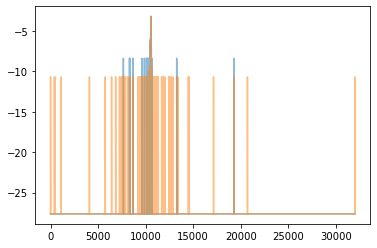

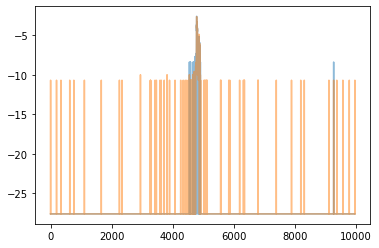

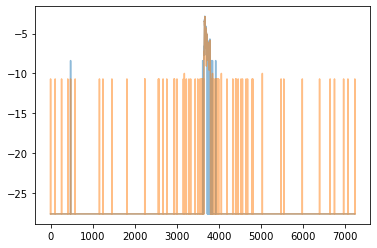

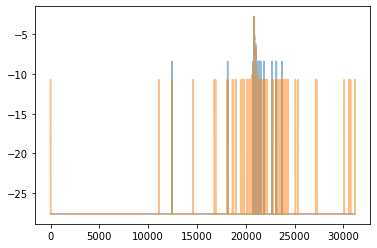

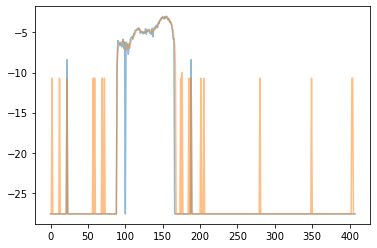

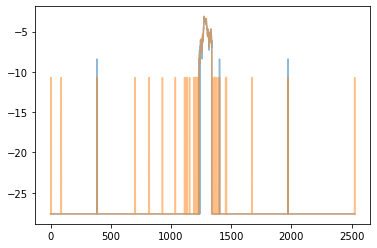

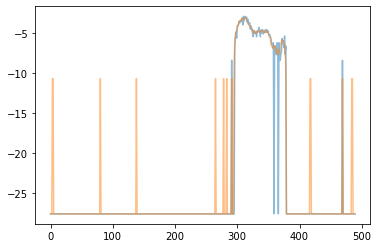

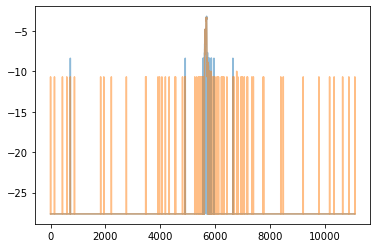

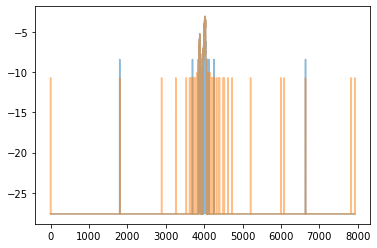

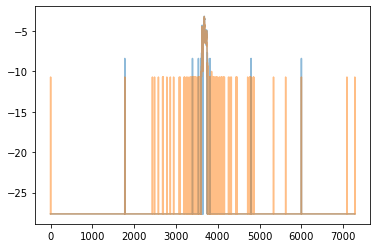

In [23]:
for i, j in zip(floda.models[0].hists_[:10], floda.main_loda.hists_[:10]):
    plt.plot(np.log(i),alpha=0.5)
    plt.plot(np.log(j),alpha=0.5)
    plt.show()

In [13]:
np.asarray([10,1])

array([10,  1])